# Pick out cues from Accelerometer data

Alternative alignment extraction path for multidevice accelerometry recordings. 

Some recordings include only one tapping or clapping cue, some include multiple.

For a single accelerometry recording:

    0. Load accelerometry file, resample and collapse to 1D absolut Jerk. 
    1. Load all relevant template cues and their approximate position.
    2. Automate IDing each synchronisation cue in the  with cross correlations.
    3. Review cue timing
    4. Save the detected timing of each cue IN DEVICE TIMESTAMP VALUES
    
Output timing information is used in a difference script to shift recordings to common concert time.

## libraries and function files

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport eq
%aimport qex
%aimport al

In [3]:
%reload_ext autoreload

# Cue Templates
Pull in the one or many cue templates used to locate cue timing in the jerk data

This sequence constructs the cue from a sequence of peak timings (claps or taps)

In [4]:
CueT={} # list of cues to check
# sample rate for comparison between cue template and signal
sf = 256
t_range= [-10,20]

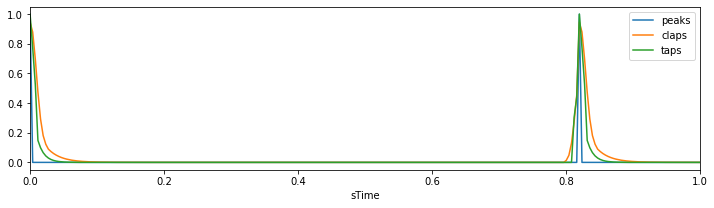

In [5]:
# tap source

cue_times = pd.read_csv('./Timing/short_synch_cue.csv',",",header=None) #SV alignment for beeps
cue_times['S_AudioTime'] = np.round(cue_times[0],3) # reset to 50 hz
cue_times['event'] = cue_times[1]
cue_times['CTime'] = cue_times['S_AudioTime']-cue_times.loc[3,'S_AudioTime'] # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['event'].str.startswith('Tap'),'CTime']

cue = al.cue_template_make(peak_times,sf,t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])
plt.xlim([0,1])
CueT['C1_Synch'] = cue

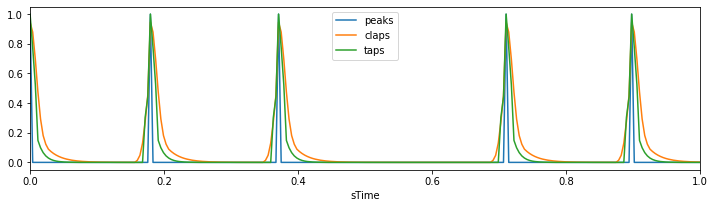

In [6]:
# riechs source
cue_times = pd.read_csv('./Timing/C1_reic_claps.csv',",") 
peak_times = list(cue_times['TIME']-cue_times.loc[0,'TIME'])

cue = al.cue_template_make(peak_times,sf,t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])
plt.xlim([0,1])
CueT['C1_Reic'] = cue

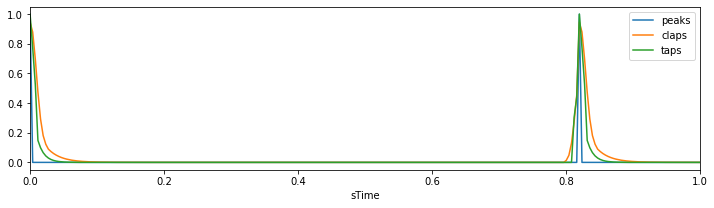

In [7]:
# tap source

cue_times = pd.read_csv('./Timing/short_synch_cue.csv',",",header=None) #SV alignment for beeps
cue_times['S_AudioTime'] = np.round(cue_times[0],3) # reset to 50 hz
cue_times['event'] = cue_times[1]
cue_times['CTime'] = cue_times['S_AudioTime']-cue_times.loc[3,'S_AudioTime'] # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['event'].str.startswith('Tap'),'CTime']

cue = al.cue_template_make(peak_times,sf,t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])
plt.xlim([0,1])
CueT['C2_Synch'] = cue

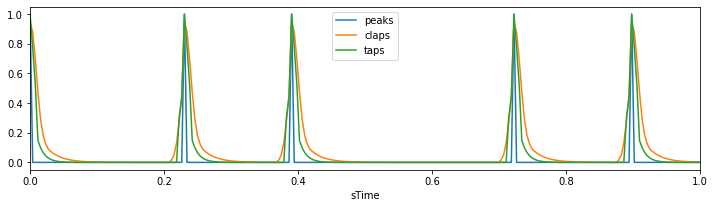

In [8]:
# riechs source
cue_times = pd.read_csv('./Timing/C2_reic_claps.csv',",") 
peak_times = list(cue_times['TIME']-cue_times.loc[0,'TIME'])

cue = al.cue_template_make(peak_times,sf,t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])
plt.xlim([0,1])
CueT['C2_Reic'] = cue

In [9]:
# Interval of time taken from signal to search for cue
cue

,sTime,peaks,taps,claps
0,-10.000000,0,0.000000e+00,0.0
1,-9.996094,0,0.000000e+00,0.0
2,-9.992188,0,0.000000e+00,0.0
3,-9.988281,0,0.000000e+00,0.0
4,-9.984375,0,0.000000e+00,0.0
...,...,...,...,...
7675,19.980469,0,9.881313e-324,0.0
7676,19.984375,0,9.881313e-324,0.0
7677,19.988281,0,9.881313e-324,0.0
7678,19.992188,0,0.000000e+00,0.0


In [10]:
CueT.keys()

dict_keys(['C1_Synch', 'C1_Reic', 'C2_Synch', 'C2_Reic'])

# Acc Data load
This notebook is initially build for processing Equivital data from the Bodies in Concert 

In [11]:
eq_data_loc = '../Data/Equivital/Lydo_C1_C2/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(eq_data_loc,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
pID = list(df_datafiles.index.unique())
pi = 0
# pid = pID[pi]
player_order = ['VN102','VN107','VN106','VN108','VN101','VN105','VN103','VN104','VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204','VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304','LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404','WW505','WW502','WW503','WW506','WW501','WW504','WW507','BR604','BR603','BR602','BR606','BR607','BR605','BR601','PC704','PC705','PC703','PC701','PC702','PC707']
pid = player_order[pi]
pi+=1

In [12]:
pid='VA304'

In [13]:
sigFileLoc = '../Data/Equivital/Lydo_C1_C2/FASTACC'+ df_datafiles.loc[pid,'FileName'][4:]
V = pd.read_csv(sigFileLoc,skipinitialspace=True)
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime']) 
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
ACC.loc[:5,:]

,dev_dTime,signal
0,2023-02-16 08:15:00.003000+00:00,0.000000
1,2023-02-16 08:15:00.007000+00:00,9.000000
2,2023-02-16 08:15:00.011000+00:00,12.369317
3,2023-02-16 08:15:00.015000+00:00,12.369317
4,2023-02-16 08:15:00.019000+00:00,8.944272
5,2023-02-16 08:15:00.023000+00:00,11.357817


# Detect cue position
Extract the interval of signal to assess against the template per cue, convert to same sample rate, and cross correlate

In [14]:
synch_times = {'C1_Reic':pd.to_datetime('2023-02-16 08:45:22.246+0000'),#'RE':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
                 'C2_Reic':pd.to_datetime('2023-02-16 10:27:10.927+0000'), # 97.0 
                 'C1_Synch':pd.to_datetime('2023-02-16 8:33:18.324+0000'),
                 'C2_Synch':pd.to_datetime('2023-02-16 10:16:22.697+0000')}

In [18]:
c = 'C1_Synch'
cue = CueT[c].copy()
xrange = [pd.to_timedelta(t_range[0],unit = 's') + synch_times[c],pd.to_timedelta(t_range[1],unit = 's') + synch_times[c]]
sig_sTime = np.linspace(t_range[0],t_range[1],sf*(t_range[1]-t_range[0]),endpoint=False)
sig_sTime

array([-10.        ,  -9.99609375,  -9.9921875 , ...,  19.98828125,
        19.9921875 ,  19.99609375])

In [19]:
X = ACC.loc[ACC['dev_dTime']<xrange[1],:].copy()
X = X.loc[X['dev_dTime']>=xrange[0],:].copy()

sig_t = (X['dev_dTime'].dt.tz_localize(None) - synch_times[c].tz_localize(None)).dt.total_seconds()
sig_v = X['signal']
f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
new_sig = f(sig_sTime)
len(sig_sTime)

7680

In [20]:
X['dev_dTime']

278610   2023-02-16 08:33:08.324000+00:00
278611   2023-02-16 08:33:08.328000+00:00
278612   2023-02-16 08:33:08.331000+00:00
278613   2023-02-16 08:33:08.335000+00:00
278614   2023-02-16 08:33:08.339000+00:00
                       ...               
286285   2023-02-16 08:33:38.304000+00:00
286286   2023-02-16 08:33:38.308000+00:00
286287   2023-02-16 08:33:38.312000+00:00
286288   2023-02-16 08:33:38.316000+00:00
286289   2023-02-16 08:33:38.320000+00:00
Name: dev_dTime, Length: 7680, dtype: datetime64[ns, UTC]

In [21]:
pd.to_timedelta(sig_sTime,unit='s')+synch_times[c]

DatetimeIndex([   '2023-02-16 08:33:08.324000+00:00',
               '2023-02-16 08:33:08.327906250+00:00',
               '2023-02-16 08:33:08.331812500+00:00',
               '2023-02-16 08:33:08.335718750+00:00',
                  '2023-02-16 08:33:08.339625+00:00',
               '2023-02-16 08:33:08.343531250+00:00',
               '2023-02-16 08:33:08.347437500+00:00',
               '2023-02-16 08:33:08.351343750+00:00',
                  '2023-02-16 08:33:08.355250+00:00',
               '2023-02-16 08:33:08.359156250+00:00',
               ...
               '2023-02-16 08:33:38.284937500+00:00',
               '2023-02-16 08:33:38.288843750+00:00',
                  '2023-02-16 08:33:38.292750+00:00',
               '2023-02-16 08:33:38.296656250+00:00',
               '2023-02-16 08:33:38.300562500+00:00',
               '2023-02-16 08:33:38.304468750+00:00',
                  '2023-02-16 08:33:38.308375+00:00',
               '2023-02-16 08:33:38.312281250+00:00',
         

In [22]:
signal = pd.DataFrame()
signal['signal'] = new_sig
signal.loc[signal['signal'].isna(),'signal'] = 0
M = signal['signal'].quantile(0.998)
signal['signal']  = signal['signal']/M
signal.loc[signal['signal']>1,'signal'] = 1
signal.loc[signal['signal']<0,'signal'] = 0
signal['sTime'] = sig_t.values
signal['dev_dTime'] = pd.to_timedelta(sig_sTime,unit='s')+synch_times[c]
signal

,signal,sTime,dev_dTime
0,0.001818,-10.000,2023-02-16 08:33:08.324000+00:00
1,0.004741,-9.996,2023-02-16 08:33:08.327906250+00:00
2,0.004311,-9.993,2023-02-16 08:33:08.331812500+00:00
3,0.002388,-9.989,2023-02-16 08:33:08.335718750+00:00
4,0.002703,-9.985,2023-02-16 08:33:08.339625+00:00
...,...,...,...
7675,0.003928,19.980,2023-02-16 08:33:38.304468750+00:00
7676,0.003977,19.984,2023-02-16 08:33:38.308375+00:00
7677,0.004386,19.988,2023-02-16 08:33:38.312281250+00:00
7678,0.003429,19.992,2023-02-16 08:33:38.316187500+00:00


In [23]:
cue['dev_dTime'] = pd.to_timedelta(sig_sTime,unit='s')+synch_times[c]
cue

,sTime,peaks,taps,claps,dev_dTime
0,-10.000000,0,0.000000e+00,0.0,2023-02-16 08:33:08.324000+00:00
1,-9.996094,0,0.000000e+00,0.0,2023-02-16 08:33:08.327906250+00:00
2,-9.992188,0,0.000000e+00,0.0,2023-02-16 08:33:08.331812500+00:00
3,-9.988281,0,0.000000e+00,0.0,2023-02-16 08:33:08.335718750+00:00
4,-9.984375,0,0.000000e+00,0.0,2023-02-16 08:33:08.339625+00:00
...,...,...,...,...,...
7675,19.980469,0,9.881313e-324,0.0,2023-02-16 08:33:38.304468750+00:00
7676,19.984375,0,9.881313e-324,0.0,2023-02-16 08:33:38.308375+00:00
7677,19.988281,0,9.881313e-324,0.0,2023-02-16 08:33:38.312281250+00:00
7678,19.992188,0,0.000000e+00,0.0,2023-02-16 08:33:38.316187500+00:00


In [24]:
sampleshift_s = cue['sTime'].diff().median()
length = np.min([len(signal),len(cue)])
length 

7680

In [ ]:
c_type = 'taps'
fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot(311)
signal.plot(x='sTime',y='signal',label=pid,ax=ax1,)
cue.plot.line(x='sTime',y=c_type,ax=ax1)
ax1.set_title(pid + ' synch alignment')
ax1.set_ylabel('Unaligned')
ax1.legend()
#plt.xlim(cue_range)

ax2 = plt.subplot(312)
CCC = ax2.xcorr(cue[c_type].iloc[:length], signal['signal'].iloc[:length], usevlines=True, maxlags=length-1, normed=True, lw=3)
ax2.grid(True)
ax2.set_xticklabels('')
#signal.index = signal.index + sampleshift_s*CCC[0][np.argmax(CCC[1])]

ax1 = plt.subplot(313)
signal.plot(x='dev_dTime',label='signal',ax=ax1,)
cue.plot.line(x='dev_dTime',y=c_type,ax=ax1)
#plt.xlim(cue_range)
ax1.grid(True)
ax1.set_title('shift '+ str(sampleshift_s*CCC[0][np.argmax(CCC[1])])+ ' s')
ax1.set_ylabel('Aligned')
#plt.saveas('')
plt.show()


In [ ]:
len(CCC[0])/len(signal)

In [338]:
signal

,signal,sTime
3.035156,0.002100,-5.000
4.035156,0.004406,-4.996
5.035156,0.003148,-4.993
6.035156,0.005035,-4.989
7.035156,0.003281,-4.985
...,...,...
7678.035156,0.003955,24.980
7679.035156,0.003068,24.984
7680.035156,0.003767,24.988
7681.035156,0.003412,24.992


In [337]:
sampleshift_s*CCC[0][np.argmax(CCC[1])]

3.03515625

In [333]:
CCC

(array([-7679, -7678, -7677, ...,  7677,  7678,  7679]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 <matplotlib.lines.Line2D at 0x14d888e20>)